It's fairly easy to greatly improve results. Initially, shots can be fired at random, but once part of a ship has been hit, it's possible to search
up, down, left and right looking for more of the same ship.

A simple implementation of this refined strategy is to create a stack of potential targets.
Initially, the computer is in **Hunt** mode, firing at random. Once a ship has been 'winged' then
the computer switches to **Target** mode. After a hit, the four surrounding grid squares are
added to a stack of 'potential' targets (or less than four if the cell was on an edge/corner).


Cells are only added if they have not already been visited (there is no point in re-visiting a cell
if we already know that it is a **Hit** or **Miss**).

Once in **Target** mode the computer pops off the next potential target off the stack, fires a
salvo at this location, acts on this (either adding more potential targets to the stack, or
popping the next target location off the stack), until either all ships have been sunk, or there
are no more potential targets on the stack, at which point it returns to Hunt mode and starts
firing at random again looking for another ship.

Looking at DataGenetics' Hunt/Target analysis, it's implemented using queue ("first-in, first-out") instead of a stack. I don't think it makes any difference, but we'll use queues to be consistent with the article.

In [1]:
from collections import deque
from Gameboard import *
from Random import *

In [2]:
%%capture
board = Gameboard()
random = Random()

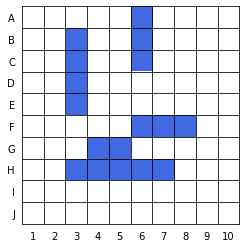

In [3]:
board.hide_ship(*random.generate_ship_locations())
board.get_figure()

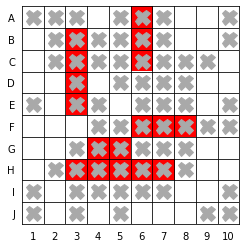

In [4]:
# create a queue for target mode
queue = deque()
# create a set of visited locations
visited_locations = set()
# we start with hunt mode
mode = 'hunt'
# counter for saving intermediate step images (optional)
#step = 0

while True:
    if mode == 'hunt':
        random_loc = random.choose()
        visited_locations.add(random_loc)
        # if shot is success, switch to target mode
        if board.shoot(random_loc):
            mode = 'target'
            # enqueue neighbouring locations of destroyed ship
            for loc in board.neighbours(random_loc):
                if loc not in visited_locations:
                    queue.append(loc)
    elif mode == 'target':
        # dequeue location
        target_loc = queue.popleft()
        # if it's visited, don't shoot
        if target_loc not in visited_locations:
            visited_locations.add(target_loc)
            # make this location unavailable for Random class because it's visited
            random.make_unavailable(target_loc)
            # if shot is success, enqueue more locations
            if board.shoot(target_loc):
                for loc in board.neighbours(target_loc):
                    if loc not in visited_locations:
                        queue.append(loc)
        # if queue is empty, go back to hunting
        if len(queue) == 0:
            mode = 'hunt'
            
    # we can save figure here (optional)
    #step += 1
    #board.get_axes().set_title('Step ' + str(step))
    #board.get_figure().savefig('hunt-and-target-steps/fig_' + str(step))
        
    if board.is_game_over():
        break
        
board.get_figure()

We see that this strategy works better than random shooting. Unfortunately, we cannot see all intermediate steps in this notebook, but we can uncomment some lines in the code above to save images of these steps in a folder.

After successfully running a single game, it's time to run multiple games to see the statistics. 

In [5]:
shots = []
accuracies = []
board.clear()
random.reset_available_locations()

for i in range(100000):
    # get ready
    queue = deque()
    visited_locations = set()
    mode = 'hunt'
    board.hide_ship(*random.generate_ship_locations())
    
    # run single game
    while True:
        if mode == 'hunt':
            random_loc = random.choose()
            visited_locations.add(random_loc)
            if board.shoot(random_loc):
                mode = 'target'
                for loc in board.neighbours(random_loc):
                    if loc not in visited_locations:
                        queue.append(loc)
        elif mode == 'target':
            target_loc = queue.popleft()
            if target_loc not in visited_locations:
                visited_locations.add(target_loc)
                random.make_unavailable(target_loc)
                if board.shoot(target_loc):
                    for loc in board.neighbours(target_loc):
                        if loc not in visited_locations:
                            queue.append(loc)
            if len(queue) == 0:
                mode = 'hunt'

        if board.is_game_over():
            break
    
    # capture statistics
    shots.append(board.get_shot_count())
    accuracies.append(board.get_accuracy())    
        
    # clean up
    board.clear()
    random.reset_available_locations()

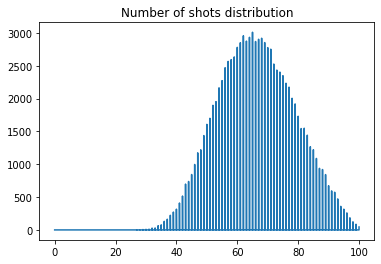

In [6]:
hist = np.histogram(shots, bins=len(shots), range=(0, 100))
plt.plot(hist[1][:-1], hist[0])
plt.title('Number of shots distribution')
plt.show()

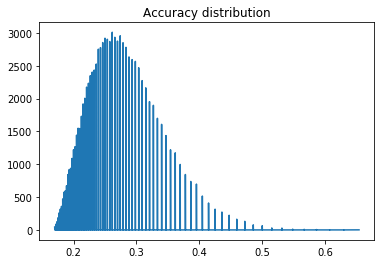

In [7]:
hist = np.histogram(accuracies, bins=len(accuracies))
plt.plot(hist[1][:-1], hist[0])
plt.title('Accuracy distribution')
plt.show()

Even though far from elegant, this algorithm produces significantly better results than random firing. It is, however, a long way from efficient as it has no concept of what constitutes a ship, and blindly needs to walk around all surrounding edges of every hit pixel (with the exception of the last hit one), making sure there are no more ships touching.